### Environment setup


In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd

import os
import random
from datetime import datetime
from dateutil.tz import gettz

import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import warnings

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image
import cv2

from tensorflow import keras as tfk
from keras import layers as tfkl
from sklearn import metrics 

warnings.filterwarnings('ignore')

In [ ]:
pip install lime

In [ ]:
import skimage
import lime
import lime.lime_tabular
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries

In [ ]:
# seed fixed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

### import dataset and model (efficientNetB2)

In [ ]:
data_dir = '/kaggle/input/corino-preprocessed'
training_dir = os.path.join(data_dir, 'train')
validation_dir = os.path.join(data_dir, 'val')
test_dir = os.path.join(data_dir, 'test')

In [ ]:
# Input Parameters
img_w = 256
img_h = 256
classes = 3
batch_size = 32

# Create an ImageDataGenerator object
datagen = ImageDataGenerator()

training_set = datagen.flow_from_directory(
        directory = training_dir,
        class_mode = 'categorical',
        color_mode = 'rgb',
        classes = None,
        seed = seed,
        target_size = (img_h, img_w),
        batch_size = batch_size,
        shuffle = True
    )

validation_set = datagen.flow_from_directory(
        directory = validation_dir,
        class_mode = 'categorical',
        color_mode = 'rgb',
        classes = None,
        seed = seed,
        target_size = (img_h, img_w),
        batch_size = 1,
        shuffle = False
    )

test_set = datagen.flow_from_directory(
        directory = test_dir,
        class_mode = 'categorical',
        color_mode = 'rgb',
        classes = None,
        seed = 1000,
        target_size = (img_h, img_w),
        batch_size = 1,
        shuffle = False
    )

Found 10834 images belonging to 3 classes.
Found 2327 images belonging to 3 classes.
Found 2309 images belonging to 3 classes.


In [ ]:
import keras.backend as K
def f1(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
model_path =  '/kaggle/input/finalmodel/kaggle/working/finetuning'
model = tfk.models.load_model(model_path, custom_objects={'f1':f1})

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
efficientnetb2 (Functional)  (None, 8, 8, 1408)        7768569   
_________________________________________________________________
gap (GlobalAveragePooling2D) (None, 1408)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1408)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               721408    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664 

In [ ]:
y_pred = model.predict(test_set)

2023-02-05 13:32:43.212822: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2023-02-05 13:32:46.254007: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


### LIME

In [ ]:
# create lime ImageExplainer
explainer = lime_image.LimeImageExplainer()

In [ ]:
#n = 15
temp = np.zeros((15, 256, 256, 3))
mask = np.zeros((15, 256, 256))
heatmap = np.zeros((15, 256, 256))

for i in range(0, 15):
    idx = random.randint(0, len(test_set))
    imglabel = test_set[idx]
    image = imglabel[0]
    image = image[0]
    image = image.astype(np.uint8)
    explanation = explainer.explain_instance(image, model.predict)
    dict_heatmap = dict(explanation.local_exp[explanation.top_labels[0]])
    heatmap[i] = np.vectorize(dict_heatmap.get)(explanation.segments) 
    temp[i], mask[i] = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, hide_rest=False)

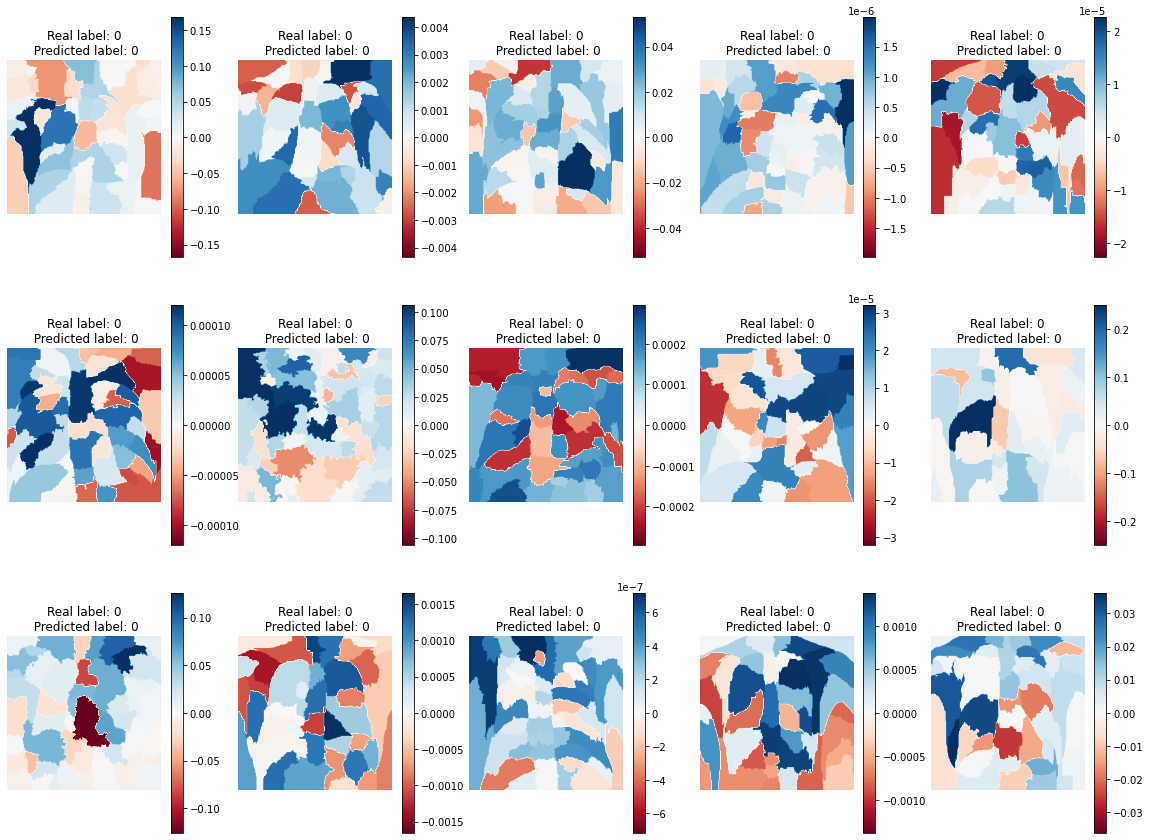

In [ ]:
#visualize heatmaps
plt.figure(figsize=(20,15))

for i in range(len(temp)):
    real_label = test_set.labels[i]
    predicted_label = np.argmax(y_pred[i])
    plt.subplot(3,5,i+1)
    plt.imshow(heatmap[i], cmap = 'RdBu', vmin  = -heatmap[i].max(), vmax = heatmap[i].max())
    plt.axis('off')
    plt.colorbar()
    plt.title('Real label: ' + str(real_label) + '\n Predicted label: ' + str(predicted_label))

In [ ]:
indexes = np.load('/kaggle/input/idx-xai/idx_occlusion.npy')

In [ ]:
### LIME on chosen idx
n = len(indexes)
temp = np.zeros((n, 256, 256, 3))
mask = np.zeros((n, 256, 256))
heatmap = np.zeros((n, 256, 256))

for i in range(0, n):
    idx = indexes[i]
    imglabel = test_set[idx]
    image = imglabel[0]
    image = image[0]
    image = image.astype(np.uint8)
    explanation = explainer.explain_instance(image, model.predict)
    dict_heatmap = dict(explanation.local_exp[explanation.top_labels[0]])
    heatmap[i] = np.vectorize(dict_heatmap.get)(explanation.segments) 
    temp[i], mask[i] = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, hide_rest=False)

In [ ]:
#np.save('heatmap.npy', heatmap)
#np.save('temp.npy', temp)
#np.save('mask.npy', mask)


heatmap = np.load('/kaggle/input/limeresults/LIME/heatmap.npy')
temp = np.load('/kaggle/input/limeresults/LIME/temp.npy')
mask = np.load('/kaggle/input/limeresults/LIME/mask.npy')

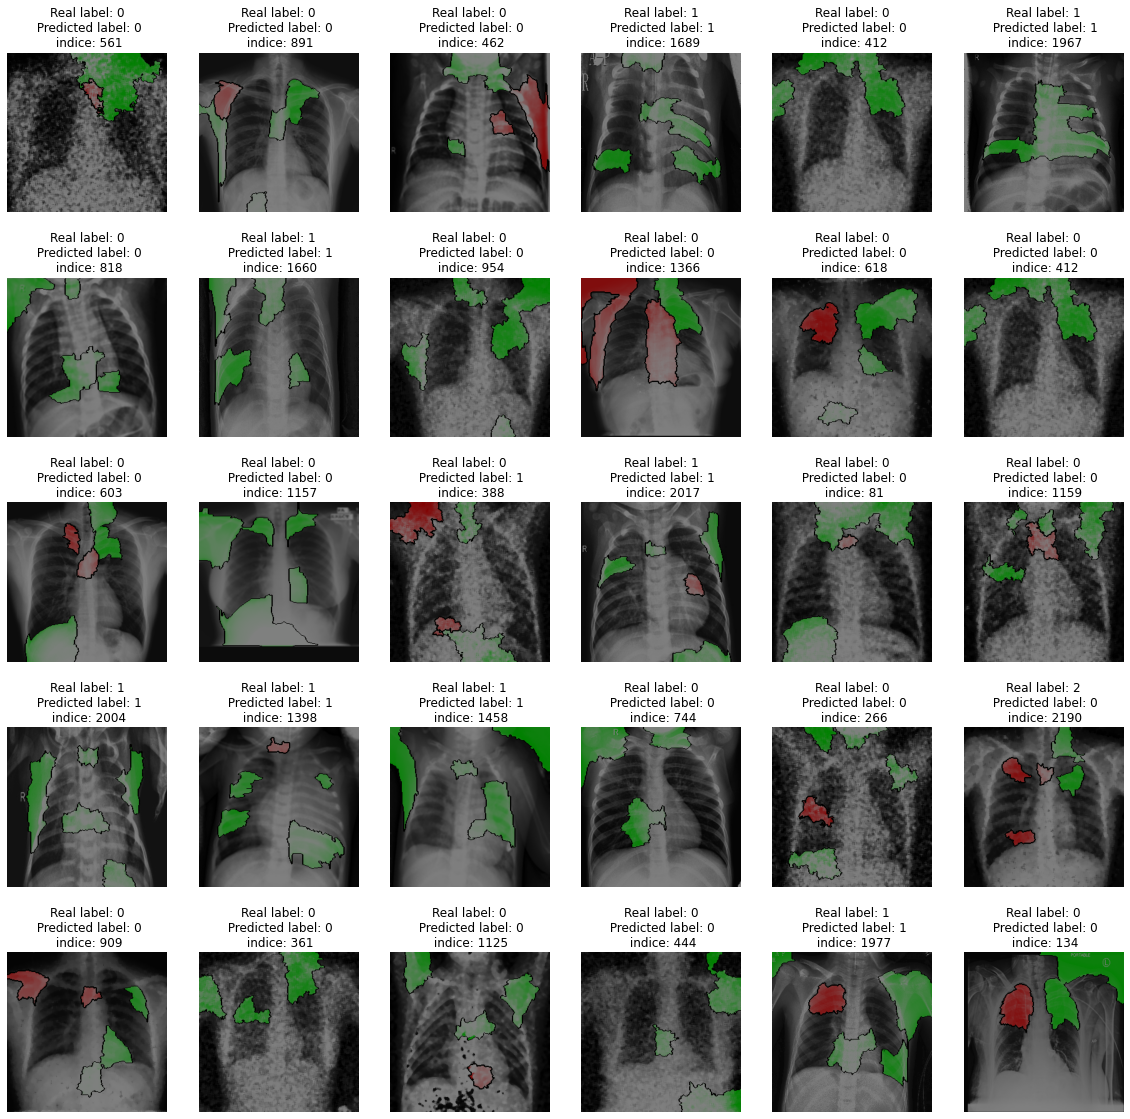

In [ ]:
#show some results
plt.figure(figsize=(20,20))

for i in range(30):
    idx = random.randint(0, 1228)
    m = mask[idx]
    t = temp[idx]
    indice = indexes[idx]
    real_label = test_set.labels[indice]
    predicted_label = np.argmax(y_pred[indice])
    plt.subplot(5,6,i+1)
    plt.imshow(mark_boundaries(t/ 2 + 0.5, m.astype(int)).astype(np.uint8))
    plt.axis('off')
    plt.title('Real label: ' + str(real_label) + '\n Predicted label: ' + str(predicted_label) + '\n index: ' + str(indice))